In [93]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
pd.set_option('max_columns',100)
pd.set_option('max_rows',100)

In [94]:
df = pd.read_csv("Downloads/fiuba-trocafone-tp1-final-set/events.csv")
df['timestamp'] = df['timestamp'].astype('datetime64')
df.head()

C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,criteo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Patrones de navegación

### Ordenamiento por timestamp y cliente

In [109]:
df.sort_values(by=['person', 'timestamp'], inplace=True)
df.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,esComprador,diff,new_session,sessionid
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,criteo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.066667,False,2819
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39,False,0.000000,False,2819
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.050000,False,2819
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.100000,False,2819
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.050000,False,2809


### Agrego columnas para identificar un id de sesión que me permita agrupar los eventos y los eventos previos

In [120]:
THRESHOLD = 10
dfWithSession = df
dfWithSession['esComprador'] = df['event'] == 'checkout'   #Genero una nueva columna para identificar la compra y por lo tanto al cliente


dfWithSession['diff'] = (dfWithSession['timestamp'] - (dfWithSession['timestamp'].shift())) / np.timedelta64(1, 'm')
dfWithSession['diff'] = dfWithSession['diff'].fillna(value=0)
dfWithSession['new_session'] = dfWithSession['diff'] > THRESHOLD 
dfWithSession['sessionid'] = dfWithSession['new_session'].cumsum()

dfWithSession.drop(columns=['diff'])
dfWithSession.sort_values(by=['person','timestamp'], inplace=True)

### Obtengo evento previo si la sesión no es nueva para entender el flujo de navegación por sesión

In [121]:
dfEventsById = dfWithSession[['person', 'sessionid', 'event', 'new_session']]

dfEventsById['evento_anterior'] = dfEventsById.event.shift(1)
dfEventsById.loc[dfEventsById['new_session'] == True, 'evento_anterior'] = None

dfEventsById.drop(columns='new_session').head()

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,person,sessionid,event,evento_anterior
1,0004b0a2,0,visited site,NaN
0,0004b0a2,0,ad campaign hit,visited site
2,0004b0a2,0,viewed product,ad campaign hit
3,0004b0a2,0,checkout,viewed product
4,0006a21a,0,viewed product,checkout


### Obtengo la frecuencia de eventos antes de una compra

In [146]:
dfCheckouts = dfEventsById.loc[dfEventsById['event'] == 'checkout']

dfCheckoutsGrouped = dfCheckouts.groupby('evento_anterior')['evento_anterior'].agg('count')
dfCheckoutsGrouped

evento_anterior
ad campaign hit       1119
brand listing          105
checkout               859
conversion             198
generic listing        179
search engine hit      318
searched products       43
staticpage              25
viewed product       27827
visited site          1844
Name: evento_anterior, dtype: int64

### Se puede ver que hay 859 casos de checkouts que preceden checkouts. Esto se debe a que se loguean consecutivamente compras. En casos particulares se observa que es la compra del mismo producto 

### Cantidad de veces que cada tipo de evento precede a una compra

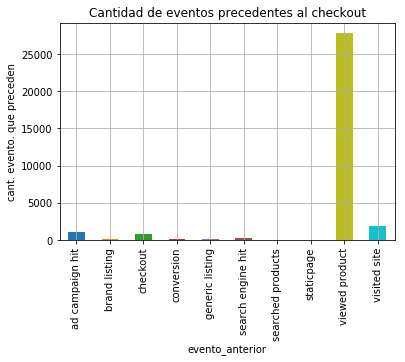

In [152]:
fig = plt.figure()
ax = dfCheckoutsGrouped.plot(kind='bar',grid=True)
plt.ylabel('cant. evento. que preceden')
plt.title('Cantidad de eventos precedentes al checkout')
plt.show();

### Cantidad de veces que cada tipo de evento precede a una compra sin considerar la vista del producto

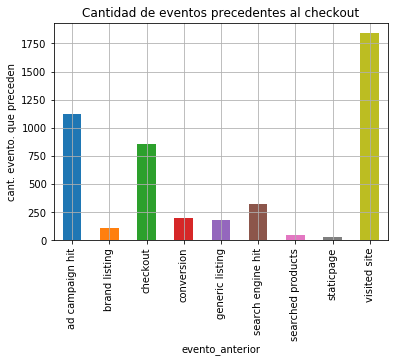

In [153]:
dfCheckouts2 = dfEventsById.loc[(dfEventsById['event'] == 'checkout') & (dfEventsById['evento_anterior'] != 'viewed product')]

dfCheckouts2Grouped = dfCheckouts2.groupby('evento_anterior')['evento_anterior'].agg('count')

fig = plt.figure()
ax = dfCheckouts2Grouped.plot(kind='bar',grid=True)
plt.ylabel('cant. evento. que preceden')
plt.title('Cantidad de eventos precedentes al checkout')
plt.show();

### Cantidad de veces que cada tipo de evento precede a la vista de un producto

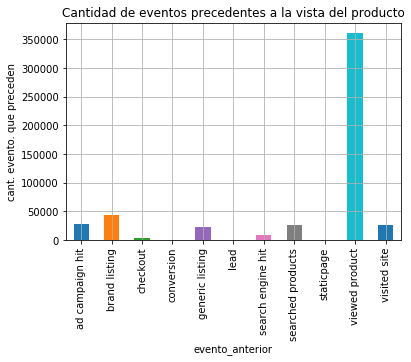

In [154]:
dfViewed = dfEventsById.loc[dfEventsById['event'] == 'viewed product']

dfViewedGrouped = dfViewed.groupby('evento_anterior')['evento_anterior'].agg('count')

fig = plt.figure()
ax = dfViewedGrouped.plot(kind='bar',grid=True)
plt.ylabel('cant. evento. que preceden')
plt.title('Cantidad de eventos precedentes a la vista del producto')
plt.show();

### Cantidad de veces que cada tipo de evento precede a un listado por marca

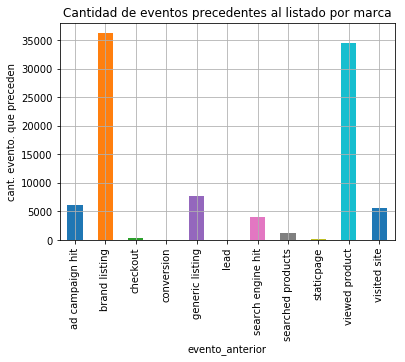

In [155]:
dfbrand = dfEventsById.loc[dfEventsById['event'] == 'brand listing']

dfbrandGrouped = dfbrand.groupby('evento_anterior')['evento_anterior'].agg('count')

fig = plt.figure()
ax = dfbrandGrouped.plot(kind='bar',grid=True)
plt.ylabel('cant. evento. que preceden')
plt.title('Cantidad de eventos precedentes al listado por marca')
plt.show();

### Cantidad de veces que cada tipo de evento precede a un listado general

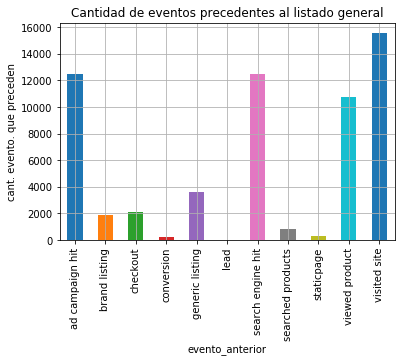

In [156]:
dfGeneric = dfEventsById.loc[dfEventsById['event'] == 'generic listing']

dfGenericGrouped = dfGeneric.groupby('evento_anterior')['evento_anterior'].agg('count')

fig = plt.figure()
ax = dfGenericGrouped.plot(kind='bar',grid=True)
plt.ylabel('cant. evento. que preceden')
plt.title('Cantidad de eventos precedentes al listado general')
plt.show();

### Cantidad de veces que cada tipo de evento precede a un search engine hit

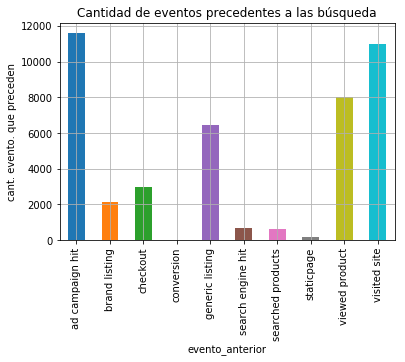

In [157]:
dfSearch = dfEventsById.loc[dfEventsById['event'] == 'search engine hit']

dfSearchGrouped = dfSearch.groupby('evento_anterior')['evento_anterior'].agg('count')

fig = plt.figure()
ax = dfSearchGrouped.plot(kind='bar',grid=True)
plt.ylabel('cant. evento. que preceden')
plt.title('Cantidad de eventos precedentes a las búsqueda')
plt.show();

### Cantidad de veces que cada tipo de evento precede a un ad campaign hit

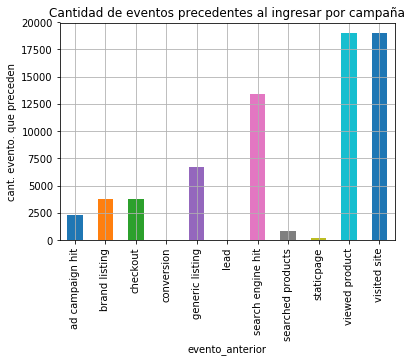

In [158]:
dfCampaign = dfEventsById.loc[dfEventsById['event'] == 'ad campaign hit']

dfCampaignGrouped = dfCampaign.groupby('evento_anterior')['evento_anterior'].agg('count')

fig = plt.figure()
ax = dfCampaignGrouped.plot(kind='bar',grid=True)
plt.ylabel('cant. evento. que preceden')
plt.title('Cantidad de eventos precedentes al ingresar por campaña')
plt.show();